In [1]:
import nltk
import string
import re,os
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import numpy as np
import math
import json

In [2]:
with open("Stopword-List.txt","r") as f:
    stop_words = f.read().split()
for i,w in enumerate(stop_words):
    stop_words[i] = ps.stem(stop_words[i])

print(stop_words)

['a', 'is', 'the', 'of', 'all', 'and', 'to', 'can', 'be', 'as', 'onc', 'for', 'at', 'am', 'are', 'ha', 'have', 'had', 'up', 'hi', 'her', 'in', 'on', 'no', 'we', 'do']


In [3]:
def isConsecChar(val):
    count = 0
    max_count=0
    for i,v in enumerate(val):
        if i==len(val)-1 and count>0:
            count+=1
            continue
        elif i<len(val)-1:
            if v==val[i+1]:
                count+=1
            else:
                count=0
        if count>max_count:
            max_count = count
        # print(f'Index: {i} Char: {v} count: {count} max_c: {max_count}')
    return max_count+1



In [4]:
docs=np.asarray([],dtype=np.int16)
filenames=os.listdir('ResearchPapers/')
for i in filenames:
    doc_id=int(i.strip('.txt'))
    docs = np.append(docs,(doc_id))
docs = np.sort(docs)
# for i in docs:
    #print((i))
print(len(docs))
print(int((np.where(docs==23))[0]))
a = 23
if a in docs:
    print(True)

20
16
True


C:\Users\Admin\AppData\Local\Temp\ipykernel_1444\1968142160.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int((np.where(docs==23))[0]))


In [5]:
vsm_index = {}
n = len(docs) # number of total docs
re1=r'[a-z]+((?:-[a-z]+)*)?'
for i in docs:
    file = os.path.join('ResearchPapers',str(i)+'.txt')
    with open(file,'r',encoding='utf-8', errors='ignore') as f:
        text = f.read()
        text=text.lower().split()
        for index, val in enumerate(text):
            if "@" not in val and ".co" not in val and "http" not in val and isConsecChar(val)<3:
                match = re.search(re1,val)
                if match:
                    val = match.group()
                    if "-" in val and val.count('-')==1:
                        val = val.replace("-","")
                    val= ps.stem(val)
                    if (val not in stop_words) and (len(val)>1) and (len(val)<16):
                        if val in vsm_index:
                            loc = int((np.where(docs==i))[0]) # gets index of the current doc in a doc vector
                            vsm_index[val][loc]+=1
                        else:
                            temp_doc_vector = np.zeros(n)
                            loc = int((np.where(docs==i))[0])
                            temp_doc_vector[loc]+=1
                            vsm_index[val] = temp_doc_vector

                        
                            

C:\Users\Admin\AppData\Local\Temp\ipykernel_1444\2701283855.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loc = int((np.where(docs==i))[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_1444\2701283855.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loc = int((np.where(docs==i))[0]) # gets index of the current doc in a doc vector


In [6]:
print(len(vsm_index))

13357


In [7]:
idf = {}

idf_vector = np.zeros(len(vsm_index))
def buildidf():
    count=0
    for i,j in vsm_index.items():
        idf[i]=np.around(np.log10(n/sum(1 for x in j if x != 0)),3) # 1. Counts the non-zeros entries for each term in vsm_index, 2. calculates idf = log(N/df) and rounds it to 3 decimal places
        idf_vector[count] = idf[i]
        count +=1
buildidf()
print(idf['overview'])
print(len(idf_vector))

0.398
13357


In [8]:
doc_tfidf = {}
count=0
re1=r'[a-z]+((?:-[a-z]+)*)?'
def filter_and_stem_text(text):
    stemmed_words = []
    for word in text.lower().split():
        if any(exclusion in word for exclusion in ["@", ".co", "http"]):
            continue
        if isConsecChar(word)>2:
            continue
        match = re.search(re1, word)
        if not match:
            continue
        word = match.group()
        if "-" in word and word.count('-') == 1:
            word = word.replace("-", "")
        stemmed_word = ps.stem(word)
        if stemmed_word not in stop_words and 1 < len(stemmed_word) < 16:
            stemmed_words.append(stemmed_word)
    return stemmed_words

for doc in docs:
    file = os.path.join('ResearchPapers',str(doc)+'.txt')
    with open(file,'r',encoding='utf-8', errors='ignore') as f:
        text = f.read()
        filtered_text = filter_and_stem_text(text)

        for idx, term in enumerate(vsm_index):
            term_frequency = filtered_text.count(term)
            if doc not in doc_tfidf:
                doc_tfidf[doc] = np.zeros(len(vsm_index))
            doc_tfidf[doc][idx] = np.around(term_frequency * idf[term], 3)

print((doc_tfidf))


            
    

{1: array([3.582, 2.107, 3.817, ..., 0.   , 0.   , 0.   ]), 2: array([1.194, 0.301, 0.   , ..., 0.   , 0.   , 0.   ]), 3: array([0.   , 0.301, 0.347, ..., 0.   , 0.   , 0.   ]), 7: array([6.766, 0.301, 5.552, ..., 0.   , 0.   , 0.   ]), 8: array([0., 0., 0., ..., 0., 0., 0.]), 9: array([0.   , 0.   , 1.388, ..., 0.   , 0.   , 0.   ]), 11: array([0., 0., 0., ..., 0., 0., 0.]), 12: array([1.194, 0.602, 0.694, ..., 0.   , 0.   , 0.   ]), 13: array([0.   , 0.301, 0.   , ..., 0.   , 0.   , 0.   ]), 14: array([0.   , 0.301, 0.   , ..., 0.   , 0.   , 0.   ]), 15: array([1.592, 5.117, 0.   , ..., 0.   , 0.   , 0.   ]), 16: array([2.786, 0.602, 0.   , ..., 0.   , 0.   , 0.   ]), 17: array([0.398, 0.   , 0.347, ..., 0.   , 0.   , 0.   ]), 18: array([0., 0., 0., ..., 0., 0., 0.]), 21: array([0.   , 0.301, 3.47 , ..., 0.   , 0.   , 0.   ]), 22: array([ 0.398,  0.   , 10.757, ...,  0.   ,  0.   ,  0.   ]), 23: array([0., 0., 0., ..., 0., 0., 0.]), 24: array([0., 0., 0., ..., 0., 0., 0.]), 25: array

In [9]:
print(len(doc_tfidf[1]))

13357


In [10]:

e_len = np.zeros(n)
count = 0
for doc in doc_tfidf:
    e_len = np.sqrt(np.sum(np.square(doc_tfidf[doc])))
    doc_tfidf[doc] = np.around(doc_tfidf[doc]/e_len,3)
    doc_tfidf[doc][np.isnan(doc_tfidf[doc])]=0

print(doc_tfidf)


{1: array([0.021, 0.012, 0.022, ..., 0.   , 0.   , 0.   ]), 2: array([0.012, 0.003, 0.   , ..., 0.   , 0.   , 0.   ]), 3: array([0.   , 0.006, 0.007, ..., 0.   , 0.   , 0.   ]), 7: array([0.023, 0.001, 0.019, ..., 0.   , 0.   , 0.   ]), 8: array([0., 0., 0., ..., 0., 0., 0.]), 9: array([0.   , 0.   , 0.017, ..., 0.   , 0.   , 0.   ]), 11: array([0., 0., 0., ..., 0., 0., 0.]), 12: array([0.003, 0.002, 0.002, ..., 0.   , 0.   , 0.   ]), 13: array([0.   , 0.004, 0.   , ..., 0.   , 0.   , 0.   ]), 14: array([0.   , 0.004, 0.   , ..., 0.   , 0.   , 0.   ]), 15: array([0.009, 0.029, 0.   , ..., 0.   , 0.   , 0.   ]), 16: array([0.019, 0.004, 0.   , ..., 0.   , 0.   , 0.   ]), 17: array([0.002, 0.   , 0.002, ..., 0.   , 0.   , 0.   ]), 18: array([0., 0., 0., ..., 0., 0., 0.]), 21: array([0.   , 0.003, 0.029, ..., 0.   , 0.   , 0.   ]), 22: array([0.002, 0.   , 0.065, ..., 0.   , 0.   , 0.   ]), 23: array([0., 0., 0., ..., 0., 0., 0.]), 24: array([0., 0., 0., ..., 0., 0., 0.]), 25: array([0., 

In [11]:
print(vsm_index.keys())

dict_keys(['overview', 'histor', 'perspect', 'explain', 'artifici', 'intellig', 'roberto', 'confalonieri', 'ludovik', 'coba', 'benedikt', 'wagner', 'tarek', 'besold', 'faculti', 'comput', 'scienc', 'free', 'univers', 'bozenbolzano', 'itali', 'research', 'centr', 'machin', 'learn', 'citi', 'london', 'uk', 'neurocat', 'gmbh', 'berlin', 'germani', 'correspond', 'ofcomput', 'ofbozenbolzano', 'ai', 'been', 'reviv', 'topic', 'ofact', 'by', 'need', 'convey', 'safeti', 'trust', 'user', 'howand', 'whyof', 'autom', 'decisionmak', 'differ', 'applic', 'such', 'autonom', 'drive', 'medic', 'diagnosi', 'or', 'bank', 'financ', 'while', 'recent', 'receiv', 'signific', 'attent', 'ori', 'gin', 'thi', 'line', 'work', 'go', 'back', 'sever', 'decad', 'when', 'system', 'weremainli', 'develop', 'knowledgebas', 'expert', 'sinc', 'then', 'defini', 'tion', 'understand', 'implement', 'pick', 'name', 'ing', 'recommend', 'approach', 'neuralsymbol', 'reason', 'mostli', 'happen', 'dure', 'period', 'histori', 'articl'

In [12]:
# Storing itfidf Index
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert numpy arrays to lists
        return json.JSONEncoder.default(self, obj)

output_filename = 'doc_tfidf.json'
doc_tfidf_str_keys = {str(key): value.tolist() if isinstance(value, np.ndarray) else value for key, value in doc_tfidf.items()}


# Save the dictionary to a JSON file
with open(output_filename, 'w') as json_file:
    json.dump(doc_tfidf_str_keys, json_file, cls=NumpyArrayEncoder)

In [13]:
# Load the dictionary from a JSON file
with open(output_filename, 'r') as json_file:
    doc_tfidf_loaded = json.load(json_file)

# Convert keys back to integers and lists back to numpy arrays if necessary
doc_tfidf = {int(key): np.array(value) for key, value in doc_tfidf_loaded.items()}


In [16]:
labels = {}

class_labels = {
            "Explainable Artificial Intelligence": [1, 2, 3, 7],
            "Heart Failure": [8, 9, 11],
            "Time Series Forecasting": [12, 13, 14, 15, 16],
            "Transformer Model": [17, 18, 21],
            "Feature Selection": [22, 23, 24, 25, 26]
        }
for class_name, documents in class_labels.items():
    for doc in documents:
        labels[doc] = class_name
print(labels)


{1: 'Explainable Artificial Intelligence', 2: 'Explainable Artificial Intelligence', 3: 'Explainable Artificial Intelligence', 7: 'Explainable Artificial Intelligence', 8: 'Heart Failure', 9: 'Heart Failure', 11: 'Heart Failure', 12: 'Time Series Forecasting', 13: 'Time Series Forecasting', 14: 'Time Series Forecasting', 15: 'Time Series Forecasting', 16: 'Time Series Forecasting', 17: 'Transformer Model', 18: 'Transformer Model', 21: 'Transformer Model', 22: 'Feature Selection', 23: 'Feature Selection', 24: 'Feature Selection', 25: 'Feature Selection', 26: 'Feature Selection'}


In [17]:
print(docs)

[ 1  2  3  7  8  9 11 12 13 14 15 16 17 18 21 22 23 24 25 26]


In [65]:
def split_data(test_ratio=0.2):
    # Shuffle document IDs
    document_list = np.random.permutation(docs)
    print(document_list)
    print(docs)
    # Split data into train and test sets
    num_docs = len(document_list)
    num_train = int((1 - test_ratio) * num_docs)
    train_docs = document_list[:num_train]
    test_docs = document_list[num_train:]
    # Assign labels to train and test data
    train_labels = {doc: labels[doc] for doc in train_docs}
    test_labels = {doc: labels[doc] for doc in test_docs}

    return train_docs, test_docs, train_labels, test_labels

In [67]:
train_docs, test_docs, train_labels, test_labels = split_data(0.5)

[13  7 23 11 12 26 22 25  3  2  8 18 15 14 21 16 24  1  9 17]
[ 1  2  3  7  8  9 11 12 13 14 15 16 17 18 21 22 23 24 25 26]


In [66]:
print("Train docs: ",train_docs)
print("\nTest Docs: ",test_docs)
print("\nTraining labels: ",train_labels)
print("\nTest labels: ",test_labels)
print(type(train_docs))
# train_labels={}
# test_labels = {}
# train_docs = np.array([3,8,11,12,14,15,17,18,21,26])
# for i in train_docs:
#     train_labels[i]=labels[i]
# test_docs = np.array([1,24,22,2,13,9,16,7,25,23])
# for i in test_docs:
#     test_labels[i]=labels[i]

Train docs:  [ 3 17 23 22 18 13 11 16 12  7]

Test Docs:  [24 15  2  9  8 21 26 25 14  1]

Training labels:  {3: 'Explainable Artificial Intelligence', 17: 'Transformer Model', 23: 'Feature Selection', 22: 'Feature Selection', 18: 'Transformer Model', 13: 'Time Series Forecasting', 11: 'Heart Failure', 16: 'Time Series Forecasting', 12: 'Time Series Forecasting', 7: 'Explainable Artificial Intelligence'}

Test labels:  {24: 'Feature Selection', 15: 'Time Series Forecasting', 2: 'Explainable Artificial Intelligence', 9: 'Heart Failure', 8: 'Heart Failure', 21: 'Transformer Model', 26: 'Feature Selection', 25: 'Feature Selection', 14: 'Time Series Forecasting', 1: 'Explainable Artificial Intelligence'}
<class 'numpy.ndarray'>


In [21]:
def getcos(doc1,train_docs):
    score = []
    for doc in train_docs:
        score.append((doc,np.around(np.sum(doc_tfidf[doc]*doc_tfidf[doc1]),3)))
    sorted_score = sorted(score,key=lambda x: x[1],reverse=True)
    return(sorted_score)



In [22]:
def getscore(doc1,train_docs):
    score = []
    for doc in train_docs:
        score.append((doc,np.around(np.sqrt(np.sum(np.square(doc_tfidf[doc]-doc_tfidf[doc1]))),3)))
    sorted_score = sorted(score,key=lambda x: x[1])
    return(sorted_score)

In [68]:
def classifyKNN(train_docs,train_labels,test_docs,k=7):
    predicted_labels={}
    for d in test_docs:
        temp_doc_list = []
        label_scores = {}
        temp_doc_list = getscore(d,train_docs)
        print(temp_doc_list)
        for i in range(k):
            ith_doc = temp_doc_list[i]
            if train_labels[ith_doc[0]] not in label_scores:
                label_scores[train_labels[ith_doc[0]]] = np.around(np.sum(doc_tfidf[ith_doc[0]]*doc_tfidf[d]),3)
            else:
                label_scores[train_labels[ith_doc[0]]] += np.around(np.sum(doc_tfidf[ith_doc[0]]*doc_tfidf[d]),3)
        print(label_scores)
        doc_label = max(label_scores, key=lambda k: label_scores[k])
        predicted_labels[d] = doc_label
    return predicted_labels          

In [69]:
predicted_labels = classifyKNN(train_docs,train_labels,test_docs)

[(11, 1.214), (7, 1.355), (3, 1.359), (2, 1.371), (22, 1.398), (13, 1.403), (23, 1.403), (25, 1.403), (26, 1.404), (12, 1.407)]
{'Heart Failure': 0.263, 'Explainable Artificial Intelligence': 0.209, 'Feature Selection': 0.037, 'Time Series Forecasting': 0.014}
[(7, 1.372), (13, 1.382), (2, 1.384), (22, 1.39), (3, 1.391), (23, 1.393), (25, 1.399), (26, 1.403), (12, 1.407), (11, 1.411)]
{'Explainable Artificial Intelligence': 0.126, 'Time Series Forecasting': 0.044, 'Feature Selection': 0.08399999999999999}
[(12, 1.143), (13, 1.368), (7, 1.369), (26, 1.377), (23, 1.384), (2, 1.387), (25, 1.388), (22, 1.389), (3, 1.393), (11, 1.408)]
{'Time Series Forecasting': 0.409, 'Explainable Artificial Intelligence': 0.093, 'Feature Selection': 0.129}
[(13, 0.0), (12, 1.328), (22, 1.377), (7, 1.382), (26, 1.393), (23, 1.394), (25, 1.397), (2, 1.397), (3, 1.401), (11, 1.41)]
{'Time Series Forecasting': 1.1179999999999999, 'Feature Selection': 0.132, 'Explainable Artificial Intelligence': 0.041}
[(12,

In [70]:
def calculate_metrics(predicted_lab):
    p_labels = []
    t_labels = []
    precisions = {}
    recalls = {}
    macro_index = {}

    for i,j in predicted_lab.items():
        p_labels.append(j)
        t_labels.append(labels[i])
    
    for t_l in set(t_labels):
        if t_l not in macro_index:
            macro_index[t_l] = {"TP":0,"FP":0,"FN":0}
        macro_index[t_l]["TP"] = sum(1 for true_label, predicted_label in zip(t_labels, p_labels) if true_label == predicted_label and true_label == t_l)
        macro_index[t_l]["FP"] = sum(1 for true_label, predicted_label in zip(t_labels, p_labels) if true_label != predicted_label and predicted_label==t_l )
        macro_index[t_l]["FN"] = sum(1 for true_label, predicted_label in zip(t_labels, p_labels) if true_label != predicted_label and  true_label == t_l)
        precisions[t_l] = macro_index[t_l]["TP"] / (macro_index[t_l]["TP"]+macro_index[t_l]["FP"]) if macro_index[t_l]["TP"]+macro_index[t_l]["FP"] != 0 else 0
        recalls[t_l] = macro_index[t_l]["TP"] / (macro_index[t_l]["TP"]+macro_index[t_l]["FN"]) if macro_index[t_l]["TP"]+macro_index[t_l]["FN"] != 0 else 0
    

    precision = sum(precisions[i] for i in precisions)/len(precisions)
    recall = sum(recalls[i] for i in recalls)/len(recalls)
    accuracy = sum(macro_index[label]["TP"] for label in macro_index) / len(predicted_lab)
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    print(macro_index)
    print(precisions)
    print(recalls)
    print("\nPrecision: ",precision,"Recall: ",recall,"Accuracy: ",accuracy,"F1 Score: ",f1_score)

    # return precision, recall, accuracy, f1_score
print(predicted_labels)
calculate_metrics(predicted_labels)

{8: 'Heart Failure', 18: 'Explainable Artificial Intelligence', 15: 'Time Series Forecasting', 14: 'Time Series Forecasting', 21: 'Time Series Forecasting', 16: 'Time Series Forecasting', 24: 'Feature Selection', 1: 'Explainable Artificial Intelligence', 9: 'Heart Failure', 17: 'Feature Selection'}
{'Heart Failure': {'TP': 2, 'FP': 0, 'FN': 0}, 'Time Series Forecasting': {'TP': 3, 'FP': 1, 'FN': 0}, 'Feature Selection': {'TP': 1, 'FP': 1, 'FN': 0}, 'Transformer Model': {'TP': 0, 'FP': 0, 'FN': 3}, 'Explainable Artificial Intelligence': {'TP': 1, 'FP': 1, 'FN': 0}}
{'Heart Failure': 1.0, 'Time Series Forecasting': 0.75, 'Feature Selection': 0.5, 'Transformer Model': 0, 'Explainable Artificial Intelligence': 0.5}
{'Heart Failure': 1.0, 'Time Series Forecasting': 1.0, 'Feature Selection': 1.0, 'Transformer Model': 0.0, 'Explainable Artificial Intelligence': 1.0}

Precision:  0.55 Recall:  0.8 Accuracy:  0.7 F1 Score:  0.6518518518518519


In [64]:

import time

def euclidean_distance(vec1, vec2):
    """Calculate Euclidean distance between two vectors."""
    return np.around(np.sqrt(np.sum(np.square(vec1-vec2))),3)

def calculate_centroid(cluster):
    l = len(cluster)
    print("Cluster for calculating centroid: ",cluster)
    n_centroid = np.zeros(len(doc_tfidf[1]))
    for i in range(l):
        n_centroid+=doc_tfidf[cluster[i]]
    try:
        n_centroid*=(1/l)
    except:
        n_centroid*=1
    return n_centroid


def initialize_centroids(data, k,seed_docs):
    """Randomly initialize K centroids."""
    np.random.seed(int(time.time()))  # for reproducibility
    indices = np.random.choice(len(data), size=k, replace=False)
    centroids = np.array([doc_tfidf[data[index]] for index in indices])
    print("\nInitial Docs: ")
    for i in indices:
        seed_docs.append(data[i])
        print(data[i]," ")
    return centroids

# print(initialize_centroids(docs,5))

def build_clusters(docs,centroids,k=5):
    clusters = {i: [] for i in range(k)}
    for doc in docs:
        distances = [euclidean_distance(doc_tfidf[doc],centroid) for centroid in centroids]
        min_dis_cen = np.argmin(distances)
        clusters[min_dis_cen].append(doc)
    return clusters

def build_initial_clusters(docs,centroids,k,seed_docs):
    clusters = {i: [] for i in range(k)}
    for doc in docs:
        if doc not in seed_docs:
            distances = [euclidean_distance(doc_tfidf[doc],centroid) for centroid in centroids]
            min_dis_cen = np.argmin(distances)
            clusters[min_dis_cen].append(doc)
    return clusters

print(build_clusters(docs,initialize_centroids(docs,5,[]),5))

def update_centroids(clusters,centroids):
    for c_id,c_docs in clusters.items():
        centroids[c_id] = calculate_centroid(c_docs)
    return centroids

def calculate_rss(clusters, centroids):
    """Calculate the Residual Sum of Squares."""
    rss = 0
    for cluster_id in range(len(clusters)):
        for doc in clusters[cluster_id]:
            rss+= np.around(np.square(euclidean_distance(doc_tfidf[doc],centroids[cluster_id])),3)
    return rss









13357

Initial Docs: 
21  
16  
13  
11  
25  
{0: [18, 21], 1: [2, 3, 7, 12, 15, 16, 17], 2: [1, 13, 14], 3: [8, 9, 11], 4: [22, 23, 24, 25, 26]}


In [62]:
def kmeans(docs,k=5):
    clusters=[]
    seed_docs=[]
    counter=0
    centroids= initialize_centroids(docs,k,seed_docs)
    clusters = build_initial_clusters(docs,centroids,k,seed_docs)
    new_rss = calculate_rss(clusters,centroids)
    rss = float("inf")
    print("Initial Data: \nRSS: {}\nClusters: {}\nCentroids: {}".format(rss,clusters,centroids))
    while new_rss>0 and new_rss<rss:
        counter+=1
        rss = new_rss
        centroids = update_centroids(clusters,centroids)
        clusters = build_clusters(docs,centroids,k)
        new_rss = calculate_rss(clusters,centroids)
        print("Iteration # {} : \nRSS: {}\nClusters: {}\nCentroids: {}".format(counter,new_rss,clusters,centroids))
    return rss, clusters

def start_Kmean(k):
    rss = float('inf')
    new_rss, clusters = kmeans(docs,k)

    while new_rss>0 and new_rss<rss:
        rss = new_rss
        print("While loop")
        new_rss, clusters = kmeans(docs)

    return clusters

clusters = start_Kmean(5)

# 




Initial Docs: 
12  
15  
24  
16  
9  
Initial Data: 
RSS: inf
Clusters: {0: [13, 14], 1: [], 2: [22, 23, 25, 26], 3: [1, 2, 3, 7, 17, 18, 21], 4: [8, 11]}
Centroids: [[0.003 0.002 0.002 ... 0.    0.    0.   ]
 [0.009 0.029 0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.019 0.004 0.    ... 0.    0.    0.   ]
 [0.    0.    0.017 ... 0.    0.    0.   ]]
Cluster for calculating centroid:  [13, 14]
Cluster for calculating centroid:  []
Cluster for calculating centroid:  [22, 23, 25, 26]
Cluster for calculating centroid:  [1, 2, 3, 7, 17, 18, 21]
Cluster for calculating centroid:  [8, 11]
Iteration # 1 : 
RSS: 13.249
Clusters: {0: [13, 14], 1: [9, 12, 15, 16], 2: [22, 23, 24, 25, 26], 3: [1, 2, 3, 7, 17, 18, 21], 4: [8, 11]}
Centroids: [[0.         0.004      0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0005     0.         0.01675    ... 0.00175    0.00375    0.00175   ]
 [0.008285

Total Correct Assignments: 16
Purity: 0.8
Rand Index: 0.5333818446425322

Initial Docs: 
8  
18  
Initial Data: 
RSS: inf
Clusters: {0: [1, 2, 3, 7, 9, 11, 12, 24], 1: [13, 14, 15, 16, 17, 21, 22, 23, 25, 26]}
Centroids: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Cluster for calculating centroid:  [1, 2, 3, 7, 9, 11, 12, 24]
Cluster for calculating centroid:  [13, 14, 15, 16, 17, 21, 22, 23, 25, 26]
Iteration # 1 : 
RSS: 16.381
Clusters: {0: [1, 2, 3, 7, 8, 9, 11, 24], 1: [12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26]}
Centroids: [[0.007375 0.003    0.008375 ... 0.       0.       0.      ]
 [0.0032   0.0044   0.0098   ... 0.0007   0.0015   0.0007  ]]
Cluster for calculating centroid:  [1, 2, 3, 7, 8, 9, 11, 24]
Cluster for calculating centroid:  [12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26]
Iteration # 2 : 
RSS: 15.963999999999999
Clusters: {0: [1, 2, 3, 7, 8, 9, 11, 24], 1: [12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26]}
Centroids: [[0.007      0.00275    0.008125   ...

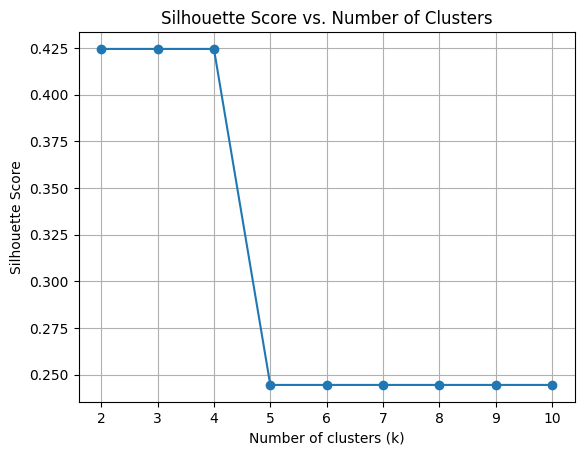

In [60]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

golden_cluster = {
            0: [1, 2, 3, 7],
            1: [8, 9, 11],
            2: [12, 13, 14, 15, 16],
            3: [17, 18, 21],
            4: [22, 23, 24, 25, 26]
        }

        
def calculate_purity(golden_clusters, test_clusters):
    total_instances = sum(len(cluster) for cluster in test_clusters.values())
    total_correct = 0
    
    for test_cluster in test_clusters.values():
        max_common = 0
        for golden_cluster in golden_clusters.values():
            common = len(set(test_cluster).intersection(golden_cluster))
            if common > max_common:
                max_common = common
        total_correct += max_common
        
    purity = total_correct / total_instances
    return total_correct, purity

# Example clusters
golden_clusters = {0: [1, 2, 3, 7], 1: [8, 9, 11], 2: [12, 13, 14, 15, 16], 3: [17, 18, 21], 4: [22, 23, 24, 25, 26]}
test_clusters = clusters

total_correct, purity = calculate_purity(golden_clusters, test_clusters)
print("Total Correct Assignments:", total_correct)
print("Purity:", purity)


def calculate_rand_index(golden_clusters, test_clusters):
    # Flatten golden and test clusters into a single list of labels
    golden_labels = []
    test_labels = []
    
    for golden_cluster_id, golden_cluster in golden_clusters.items():
        golden_labels.extend([golden_cluster_id] * len(golden_cluster))
        
    for test_cluster_id, test_cluster in test_clusters.items():
        test_labels.extend([test_cluster_id] * len(test_cluster))
    
    # Calculate the Rand index
    rand_index = adjusted_rand_score(golden_labels, test_labels)
    return rand_index

rand_index = calculate_rand_index(golden_clusters, test_clusters)
print("Rand Index:", rand_index)


def calculate_silhouette_score(test_clusters,data):
    # Flatten test clusters into a single list of labels
    labels = []
    for cluster_id, cluster in test_clusters.items():
        labels.extend([cluster_id] * len(cluster))
    
    # Convert the labels to an array
    labels = np.array(labels)
    data = data.reshape(-1, 1)
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(data, labels)
    return silhouette_avg

# Range of k values to try
k_values = range(2, 11)  # Try k from 2 to 10

# Initialize lists to store silhouette scores
silhouette_scores = []

# Iterate over different k values
for k in k_values:
    # Fit KMeans clustering model
    clusters = start_Kmean(k)
    
    # Calculate silhouette score
    silhouette_avg = calculate_silhouette_score(clusters, docs)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores vs. number of clusters
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()